# Tutorial 02: Writing first MNIST Program
By Rahul GAWAI

## Introduction
This program is inspired by [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials)

Python used: 3.6
TensorFlow version: 1.10

## Importing packages

In [157]:
import tensorflow as tf

import sys
import os
import urllib.request
import gzip
import numpy as np
import matplotlib.pyplot as plt


In [158]:

img_w = 28
img_h = 28
img_shape = (img_w, img_h)
img_shape_storage = (img_w, img_h, 1)

url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

x_train_file = "train-images-idx3-ubyte.gz"
y_train_file = "train-labels-idx1-ubyte.gz"
x_test_file = "t10k-images-idx3-ubyte.gz"
y_test_file = "t10k-labels-idx1-ubyte.gz"

target = "mnist_dataset"

x_train_url = url + x_train_file
y_train_url = url + y_train_file
x_test_url = url + x_test_file
y_test_url = url + y_test_file

x_train_rpath = target + "/" + x_train_file
y_train_rpath = target + "/" + y_train_file
x_test_rpath = target + "/" + x_test_file
y_test_rpath = target + "/" + y_test_file

training_recname = '%s/mnist_%s.tfrecord' % (target, x_train_file)
testing_recname = '%s/mnist_%s.tfrecord' % (target, x_test_file)

## Download dataset to a local folder.

In [159]:
def _print_download_progress(count, block_size, total_size):
    """
    Function used for printing the download progress.
    Used as a call-back function in maybe_download_and_extract().
    """

    # Percentage completion.
    pct_complete = float(count * block_size) / total_size

    # Limit it because rounding errors may cause it to exceed 100%.
    pct_complete = min(1.0, pct_complete)

    # Status-message. Note the \r which means the line should overwrite itself.
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [160]:
def download_img(base_url, filename, download_dir, offset):

    if not os.path.exists(download_dir):
        os.makedirs(download_dir)

    file_path = os.path.join(download_dir, filename)

    if not os.path.exists(file_path):
        print("\nDownloading", base_url, "at", download_dir, ".")
        file_path, _ = urllib.request.urlretrieve( base_url, file_path, _print_download_progress)

    with gzip.open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=offset)

    img_size = 28
    img_size_flat = img_size * img_size
    num_channels = 1
    img_shape_full = (img_size, img_size, num_channels)
    images_flat = data.reshape(-1, img_size_flat)
    return images_flat

def download_cls(base_url, filename, download_dir,  offset):

    if not os.path.exists(download_dir):
        os.makedirs(download_dir)

    file_path = os.path.join(download_dir, filename)

    if not os.path.exists(file_path):
        print("\nDownloading", base_url, "at", download_dir, ".")
        file_path, _ = urllib.request.urlretrieve( base_url, file_path, _print_download_progress)

    with gzip.open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8,  offset=offset)
        
    return data

In [161]:
print()

#save_path = os.path.join(download_dir, filename)

x_train = download_img(x_train_url, x_train_file, target,16)
print("x_train Set", len(x_train))

y_train_cls = download_cls(y_train_url, y_train_file, target,8)
print("y_train_cls Set", len(y_train_cls))

x_test = download_img(x_test_url, x_test_file, target,16)
print("x_test Set", len(x_test))

y_test_cls = download_cls(y_test_url, y_test_file, target,8)
print("y_test_cls Set", len(y_test_cls))



x_train Set 60000
y_train_cls Set 60000
x_test Set 10000
y_test_cls Set 10000


In [162]:
num_train = 60000
num_val = 5000
num_test = 10000

X_train = x_train[0:num_train] / 255.0
Y_train_cls = y_train_cls[0:num_train]

X_val = x_train[num_train:] / 255.0
Y_val_cls = y_train_cls[num_train:]

print("Training Set", len(X_train), " images and ", len(Y_train_cls), " classes.")
print("Validation Set", len(X_val), " images and ", len(Y_val_cls), " classes.")

X_test = x_test[0:num_test] / 255.0
Y_test_cls = y_test_cls[0:num_test]

print("Test Set", len(X_test), " images and ", len(Y_test_cls), " classes.")

Training Set 60000  images and  60000  classes.
Validation Set 0  images and  0  classes.
Test Set 10000  images and  10000  classes.


In [163]:
def plot_images(images, cls_true, cls_pred=None, img_w=28, img_h=28):
    assert len(images) == len(cls_true) == 9


    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

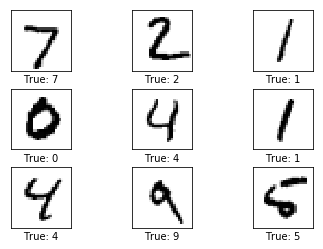

In [164]:
# Get the first images from the test-set.
images = X_test[0:9]

# Get the true classes for those images.
cls_true = Y_test_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## One Hot Encoding

In [165]:
y_train_cls_char = Y_train_cls.astype(np.int)
y_val_cls_char = Y_val_cls.astype(np.int)
y_test_cls_char = Y_test_cls.astype(np.int)

Y_train_OHE = np.eye(10, dtype=float)[y_train_cls_char]
Y_val_OHE = np.eye(10, dtype=float)[y_val_cls_char]
Y_test_OHE = np.eye(10, dtype=float)[y_test_cls_char]

Y_test_OHE[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

## TF-record (Optional)

[Referred this implementation to create tf.record](https://github.com/tensorflow/models/blob/master/research/slim/datasets/download_and_convert_mnist.py)

In [166]:
def int64_feature(values):
  if not isinstance(values, (tuple, list)):
    values = [values]
  return tf.train.Feature(int64_list=tf.train.Int64List(value=values))

In [167]:
def image_to_tfexample(image_data, image_format, height, width, class_id):
  return tf.train.Example(features=tf.train.Features(feature={
      'image/encoded':  tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_data])),
      'image/format':  tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_format])),
      'image/class/label': int64_feature(class_id),
      'image/height': int64_feature(height),
      'image/width': int64_feature(width)
  }))

In [168]:
def _add_to_tfrecord(data_filename, labels_filename, num_images, tfrecord_writer, images, labels):
    with tf.Graph().as_default():
        image = tf.placeholder(dtype=tf.uint8, shape=img_shape_storage)
        encoded_png = tf.image.encode_png(image)

        num_images = len(images)
        images = images.reshape(-1, img_w, img_h, 1)

        with tf.Session('') as sess:
            for j in range(num_images):
                sys.stdout.write('\r>> Converting image %d/%d' % (j + 1, num_images))
                sys.stdout.flush()

                png_string = sess.run(encoded_png, feed_dict={image: images[j]})
                example = image_to_tfexample(png_string, 'png'.encode(), img_w, img_h, labels[j])
                tfrecord_writer.write(example.SerializeToString())

#                pngFname = target + "/" + "train_%d.png" % (j)
#                pngFile=open(pngFname,'wb')
#                pngFile.write(png_string);
#                pngFile.close()


In [169]:
x_train = download_img(x_train_url, x_train_file, target,16)
print("x_train Set", len(x_train))

y_train_cls = download_cls(y_train_url, y_train_file, target,8)
print("y_train_cls Set", len(y_train_cls))

x_test = download_img(x_test_url, x_test_file, target,16)
print("x_test Set", len(x_test))

y_test_cls = download_cls(y_test_url, y_test_file, target,8)
print("y_test_cls Set", len(y_test_cls))

print(len(x_train))

if not os.path.exists(training_recname):
    with tf.python_io.TFRecordWriter(training_recname) as tfrecord_writer:
        _add_to_tfrecord(x_train_rpath, y_train_rpath, 60000, tfrecord_writer, x_train, y_train_cls)

if not os.path.exists(testing_recname):
    with tf.python_io.TFRecordWriter(testing_recname) as tfrecord_writer:
        _add_to_tfrecord(x_test_rpath, y_test_rpath, 10000, tfrecord_writer, x_test, y_test_cls)

x_train Set 60000
y_train_cls Set 60000
x_test Set 10000
y_test_cls Set 10000
60000


## Main Function()

In [170]:
def parser(record):
    keys_to_features = {
        "image/encoded":  tf.FixedLenFeature([], tf.string),
        "image/format":  tf.FixedLenFeature([], tf.string),
        "image/class/label": tf.FixedLenFeature([], tf.int64),
        "image/height": tf.FixedLenFeature([], tf.int64),
        "image/width": tf.FixedLenFeature([], tf.int64)
    }

    parsed = tf.parse_single_example(record, keys_to_features)

    height = tf.cast(parsed["image/height"], tf.int32)
    width = tf.cast(parsed["image/width"], tf.int32)
    label = tf.cast(parsed["image/class/label"], tf.int32)
    image = tf.cast(tf.image.decode_png(parsed["image/encoded"], channels=1), tf.float32)
    
 
    return {'image': image}, label

In [171]:
def input_fn(filenames):
    
    BATCH_SIZE = 128
    THREADS = 4
    PREFETCH = 64
    
    dataset = tf.data.TFRecordDataset(filenames=filenames, num_parallel_reads=THREADS)
    dataset = dataset.apply(
        tf.contrib.data.shuffle_and_repeat(1024, 1)
    )
    dataset = dataset.apply(
        tf.contrib.data.map_and_batch(parser, BATCH_SIZE)
    )

    dataset = dataset.prefetch(buffer_size=PREFETCH)
    return dataset

In [172]:
def train_input_fn():
    return input_fn(filenames=[training_recname])

In [173]:
def val_input_fn():
    return input_fn(filenames=[testing_recname])

In [174]:
def cnn_model_fn(features, labels, mode, params):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel

    # Print all of the operations in the default graph.


    net = features["image"]

    net = tf.identity(net, name="input_tensor")

    net = tf.reshape(net, [-1, 28, 28, 1])

    # Convolutional Layer #1
    # Computes 32 features using a 5x5 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 28, 28, 1]
    # Output Tensor Shape: [batch_size, 28, 28, 32]
    conv1 = tf.layers.conv2d(inputs=net, filters=32,kernel_size=[5, 5],padding="same", activation=tf.nn.relu)

    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 28, 28, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2
    # Computes 64 features using a 5x5 filter.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 14, 14, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 64]
    conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)

    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 14, 14, 64]
    # Output Tensor Shape: [batch_size, 7, 7, 64]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 7, 7, 64]
    # Output Tensor Shape: [batch_size, 7 * 7 * 64]
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 1024]
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

    # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        "classes": tf.argmax(input=logits, axis=1), "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)


    if mode == tf.estimator.ModeKeys.TRAIN:
        # Call rewriter to produce graph with fake quant ops and folded batch norms
        # quant_delay delays start of quantization till quant_delay steps, allowing
        # for better model accuracy.
        g = tf.get_default_graph()
        tf.contrib.quantize.create_training_graph(input_graph=g, quant_delay=10)

    if mode == tf.estimator.ModeKeys.EVAL:
        # Call the eval rewrite which rewrites the graph in-place with
        # FakeQuantization nodes and fold batchnorm for eval.
        g = tf.get_default_graph()
        tf.contrib.quantize.create_eval_graph(input_graph=g)     


    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss,global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])
    }

    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [175]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

model = tf.estimator.Estimator(model_fn=cnn_model_fn,
                               params={"learning_rate": 1e-4},
                               model_dir="02_QAT_MNIST")

import timeit

EPOCHS = 15
STEP_SIZE = 100
count = 0

while (count < EPOCHS):
    start_time = timeit.default_timer()
    model.train(input_fn=train_input_fn, steps=STEP_SIZE)
    elapsed = timeit.default_timer() - start_time
    sys.stdout.write("Time Take per Iternation of training is : {0:%}".format(elapsed))

    result = model.evaluate(input_fn=val_input_fn)
    #print(result)
    sys.stdout.write("Classification accuracy: {0:.2%}".format(result["accuracy"]))
    sys.stdout.flush()
    count = count + 1

    

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '02_QAT_MNIST', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd09bb61390>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into 02_QAT_MNIST/model.ckpt.
INFO:tensorflow:

INFO:tensorflow:Saving checkpoints for 600 into 02_QAT_MNIST/model.ckpt.
INFO:tensorflow:loss = 0.13471556, step = 600
INFO:tensorflow:Saving checkpoints for 700 into 02_QAT_MNIST/model.ckpt.
INFO:tensorflow:Loss for final step: 0.21908486.
Time Take per Iternation of training is : 219.035619%INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-08-01:40:26
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from 02_QAT_MNIST/model.ckpt-700
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-01-08-01:40:26
INFO:tensorflow:Saving dict for global step 700: accuracy = 0.963, global_step = 700, loss = 0.12450473
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 700: 02_QAT_MNIST/model.ckpt-700
Classification accuracy: 96.30%INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Cre

Classification accuracy: 97.23%INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from 02_QAT_MNIST/model.ckpt-1300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1300 into 02_QAT_MNIST/model.ckpt.
INFO:tensorflow:loss = 0.052548505, step = 1300
INFO:tensorflow:Saving checkpoints for 1400 into 02_QAT_MNIST/model.ckpt.
INFO:tensorflow:Loss for final step: 0.17545208.
Time Take per Iternation of training is : 210.382798%INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-08-01:40:44
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from 02_QAT_MNIST/model.ckpt-1400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2

In [178]:
def make_serving_input_receiver_fn():
    inputs = {'image': tf.placeholder(shape=[28,28,1], dtype=tf.float32, name='image')}
    return tf.estimator.export.build_raw_serving_input_receiver_fn(inputs)

export_dir = os.path.join('./02_QAT_MNIST/', 'export')

if tf.gfile.Exists(export_dir):
        tf.gfile.DeleteRecursively(export_dir)

model.export_savedmodel(export_dir_base=export_dir,serving_input_receiver_fn=make_serving_input_receiver_fn(),as_text=False)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from 02_QAT_MNIST/model.ckpt-1500
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./02_QAT_MNIST/export/temp-b'1546911648'/saved_model.pb


b'./02_QAT_MNIST/export/1546911648'

In [179]:
export_dir = os.path.join('./02_QAT_MNIST/', 'export')
saved_model_dir = os.path.join(export_dir, os.listdir(export_dir)[-1]) 

predictor_fn = tf.contrib.predictor.from_saved_model(
  export_dir = saved_model_dir)



INFO:tensorflow:Restoring parameters from ./02_QAT_MNIST/export/1546911648/variables/variables


Text(0.5, 1.0, 'Result: Pred. No. : 8')

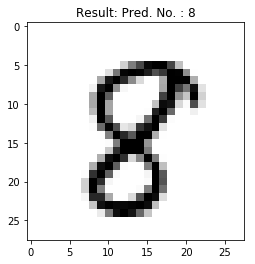

In [180]:
import numpy
import random

dir = target + "/PNGs/"
pngFname = dir + random.choice(os.listdir(dir))

pngFile=open(pngFname,'rb')
png_string = pngFile.read();
pngFile.close()

#sample = tf.cast(tf.image.decode_png(png_string, channels=1), tf.int8)
sample = tf.cast(tf.image.decode_png(png_string, channels=1), tf.float32)

a = np.ones(shape=(28,28,1),dtype=np.float32)    

img = tf.reshape(sample, [28, 28, 1])

with sess.as_default():
    a = img.eval()

output = predictor_fn({'image': a})
#print(output)
#print ("train_data.shape: " + str(sample.get_shape()))
#print ("train_data.shape: " + str(img.get_shape()))

max = 0

for x in range(10):
    if output['probabilities'][0][x] >= output['probabilities'][0][max]:
        max = x

f, ax = plt.subplots()
ax.imshow(a.reshape(img_shape), cmap='binary')
xlabel = "Result: Pred. No. : {0}".format(max)
ax.set_title(xlabel)
